In [4]:
import top_k
import numpy as np
import pandas as pd

# Namaak benade 2018

In [5]:
# using project costs and utils from benade 2018
budget = 65
P = 10

project_prizes= {0:10, 1:20, 2:3, 3:8, 4:5, 5:5, 6:10, 7:10, 8:30, 9:25}
possible_sets = top_k.get_possible_sets(project_prizes, budget)

In [6]:
N = 720
epsilon = 15

base_util = np.asarray([5.8, 2.3, 29.3, 9.5, 14.8, 9.4, 5.4, 14.9, 6.7, 1.9])
utilities = top_k.make_voter_utils(base_util, epsilon, N)

In [7]:
max_set = top_k.max_utility(possible_sets, utilities)


In [8]:
for k in range(1, P):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(votes)
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, project_prizes)
        dist_score = top_k.calc_dist_score(winners, max_set, utilities)

#         print("util", util_score)
#         print("egal", egal_score)
#         print("comp", comp_score)
#         print("dist", dist_score)

---------k------------ 1
Counter({9: 144, 1: 141, 6: 111, 8: 83, 0: 76, 3: 68, 5: 44, 7: 25, 4: 24, 2: 4})
---------k------------ 2
Counter({9: 253, 1: 252, 6: 206, 0: 177, 8: 173, 3: 121, 5: 114, 4: 66, 7: 65, 2: 13})
---------k------------ 3
Counter({1: 351, 9: 348, 6: 289, 0: 266, 8: 260, 5: 194, 3: 190, 7: 128, 4: 113, 2: 21})
---------k------------ 4
Counter({1: 435, 9: 430, 6: 380, 8: 347, 0: 343, 3: 273, 5: 270, 7: 195, 4: 169, 2: 38})
---------k------------ 5
Counter({9: 507, 1: 507, 6: 453, 0: 428, 8: 422, 3: 357, 5: 352, 7: 275, 4: 233, 2: 66})
---------k------------ 6
Counter({1: 577, 9: 569, 6: 528, 0: 510, 8: 491, 3: 438, 5: 437, 7: 361, 4: 306, 2: 103})
---------k------------ 7
Counter({1: 635, 9: 624, 6: 586, 0: 574, 8: 571, 5: 535, 3: 515, 7: 444, 4: 395, 2: 161})
---------k------------ 8
Counter({1: 681, 9: 667, 0: 647, 8: 643, 6: 639, 5: 602, 3: 587, 7: 532, 4: 494, 2: 268})
---------k------------ 9
Counter({1: 708, 9: 699, 8: 696, 6: 690, 0: 685, 5: 685, 3: 665, 7: 6

In [9]:
df = pd.read_csv("results/results_P10_ep15_N720_B65_min10_max25_L100.csv")

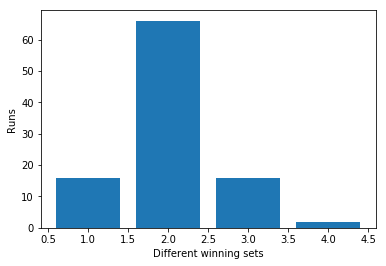

In [10]:
from collections import Counter
from matplotlib import pyplot as plt

winners = []
for i, row in df.iterrows():
    win = []
    for i in range(1,10):
        get = "k_" + str(i) + "_winners"
        win.append(int(row[get]))
    winners.append(win)
    
winner_sets = []
for i, result in enumerate(winners):
    winner_sets.append(len(set(result)))
    
c = Counter(winner_sets)
plt.bar(list(c.keys()), c.values())
plt.xlabel("Different winning sets")
plt.ylabel("Runs")
plt.show()

# Epistemic accuracy

In [248]:
from collections import defaultdict
from sklearn.preprocessing import normalize


def prob_utils(probs, k, N):
    votes = []
    projects = list(range(len(probs)))
    # Create noisy prob vectors for voters
    probs = np.tile(probs, (N,1))
    noise = np.random.normal(0.07, 0.05, (N, len(projects)))
    probs += noise
    # Set all negative probs to 0 and 
    probs[probs < 0] = 0
    probs = normalize(probs, "l1", axis=1)
    # Every voters uses prob distr to vote
    for i in range(N):
        vote = np.random.choice(projects, k, replace=False, p=probs[i])
        votes += list(vote)
    return Counter(votes)


In [249]:
P = 10 
epsilon = 20
N = 500
budget = 40
min_prize = 5
max_prize = 20

In [250]:
values = top_k.make_base_util(P)
probs = values / np.sum(values)
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
best_set = top_k.best_outcome(values, possible_sets)

In [251]:
prob_utils(probs, 3, N)

1.0


Counter({0: 158,
         1: 170,
         2: 242,
         3: 84,
         4: 86,
         5: 218,
         6: 172,
         7: 58,
         8: 228,
         9: 84})

In [114]:
utilities = top_k.make_voter_utils(values, epsilon, N)
print(utilities[0])
print(values)

[0.09869167 0.05934522 0.17081058 0.05289539 0.05862511 0.17312552
 0.01908166 0.22200886 0.         0.14541599]
[0 4 9 3 4 2 1 5 8 6]


In [112]:
for k in range(1, P):
    print("---------k------------", k)
    # calculate scores for all projects
    votes = top_k.k_approval(k, utilities, P)
    print(votes)
    
    # determine the winning projects
    winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
    # Epistemic accuracy
    print("win:", list(winners), "--best",  best_set[0])
    correct = 0
    for alt in list(winners):
        if alt in best_set[0]:
            correct += 1
    
    acc = correct/len(best_set[0])
    print(acc)
                


---------k------------ 1
Counter({0: 72, 6: 60, 3: 59, 1: 52, 5: 50, 7: 47, 4: 46, 9: 44, 8: 38, 2: 32})
win: [0, 3, 4, 5, 6] --best [6, 7, 8, 9]
0.25
---------k------------ 2
Counter({0: 145, 6: 111, 3: 109, 7: 104, 5: 102, 1: 101, 9: 84, 2: 82, 4: 81, 8: 81})
win: [0, 3, 6, 7] --best [6, 7, 8, 9]
0.5
---------k------------ 3
Counter({0: 201, 6: 167, 5: 157, 7: 152, 3: 147, 1: 146, 4: 142, 9: 141, 8: 125, 2: 122})
win: [0, 4, 5, 6, 7] --best [6, 7, 8, 9]
0.5
---------k------------ 4
Counter({0: 259, 6: 218, 5: 209, 3: 205, 7: 199, 4: 195, 9: 193, 1: 188, 8: 171, 2: 163})
win: [0, 3, 4, 5, 6] --best [6, 7, 8, 9]
0.25
---------k------------ 5
Counter({0: 316, 6: 282, 5: 263, 3: 259, 7: 250, 4: 241, 9: 236, 1: 235, 8: 216, 2: 202})
win: [0, 3, 4, 5, 6] --best [6, 7, 8, 9]
0.25
---------k------------ 6
Counter({0: 362, 6: 334, 5: 314, 3: 302, 4: 301, 7: 295, 1: 290, 9: 284, 8: 266, 2: 252})
win: [0, 3, 4, 5, 6] --best [6, 7, 8, 9]
0.25
---------k------------ 7
Counter({0: 404, 6: 372, 7: 